Neural Linear Model Uncertainty Quantification.

Translated to JAX from https://colab.research.google.com/drive/1bOS3CcLukgjs-0-spm5GvwTBK7jgoDnc?usp=sharing#scrollTo=YwmW2StCzixH

# 0. Imports, Dataset, and MLP Model

In [1]:
from typing import Sequence
from functools import partial

from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree
from jax import vmap, jit, value_and_grad, jacrev
import seaborn as sns
import optax
import ml_collections
from flax.training import train_state
from flax import linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from rebayes.base import RebayesParams
from rebayes.low_rank_filter.lofi import RebayesLoFi, LoFiParams

rc = {
    "figure.constrained_layout.use": True,
    "axes.titlesize": 20,
    "figure.figsize": (12, 9),
}
sns.set_theme(style="darkgrid", palette="colorblind", rc=rc)

2023-02-24 13:04:10.749361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-24 13:04:11.605322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-24 13:04:11.605465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2023-02-24 13:04:11.605476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use

In [34]:
def generate_dataset(n_train, obs_var, key=42, in_between=False):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    
    if in_between:
        mask = jr.bernoulli(key, p=0.5, shape=(n_train,))
        key1, key2, subkey = jr.split(subkey, 3)
        X_train = (-2 * jr.uniform(key1, (n_train,)) - 1) * mask + \
            (2 * jr.uniform(key2, (n_train,)) + 1) * (1. - mask)
    else:
        X_train = jr.normal(key, (n_train,))

    w = jnp.array([-0.6667, -0.6012, -1.0172, -0.7687, 1.4680, -0.1678])
    def f(x, key):
        fx = w @ jnp.power(x, jnp.arange(len(w)))
        fx *= jnp.sin(jnp.pi * x)
        fx *= jnp.exp(-0.5 * (x**2)) / jnp.sqrt(2 * jnp.pi)
        return fx + obs_var * jr.normal(key)
    
    keys = jr.split(subkey, n_train)
    y_train = vmap(f)(X_train, keys)

    return X_train, y_train


In [35]:
def get_adamw_config(learning_rate=0.01, weight_decay=1e-4, batch_size=1, num_epochs=1):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.learning_rate = learning_rate
    config.weight_decay = weight_decay
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    return config


Generate full dataset

In [36]:
n_train = 200
obs_var = 0.1

X_train, y_train = generate_dataset(n_train, obs_var)
X_grid = jnp.linspace(-4, 4, 150)

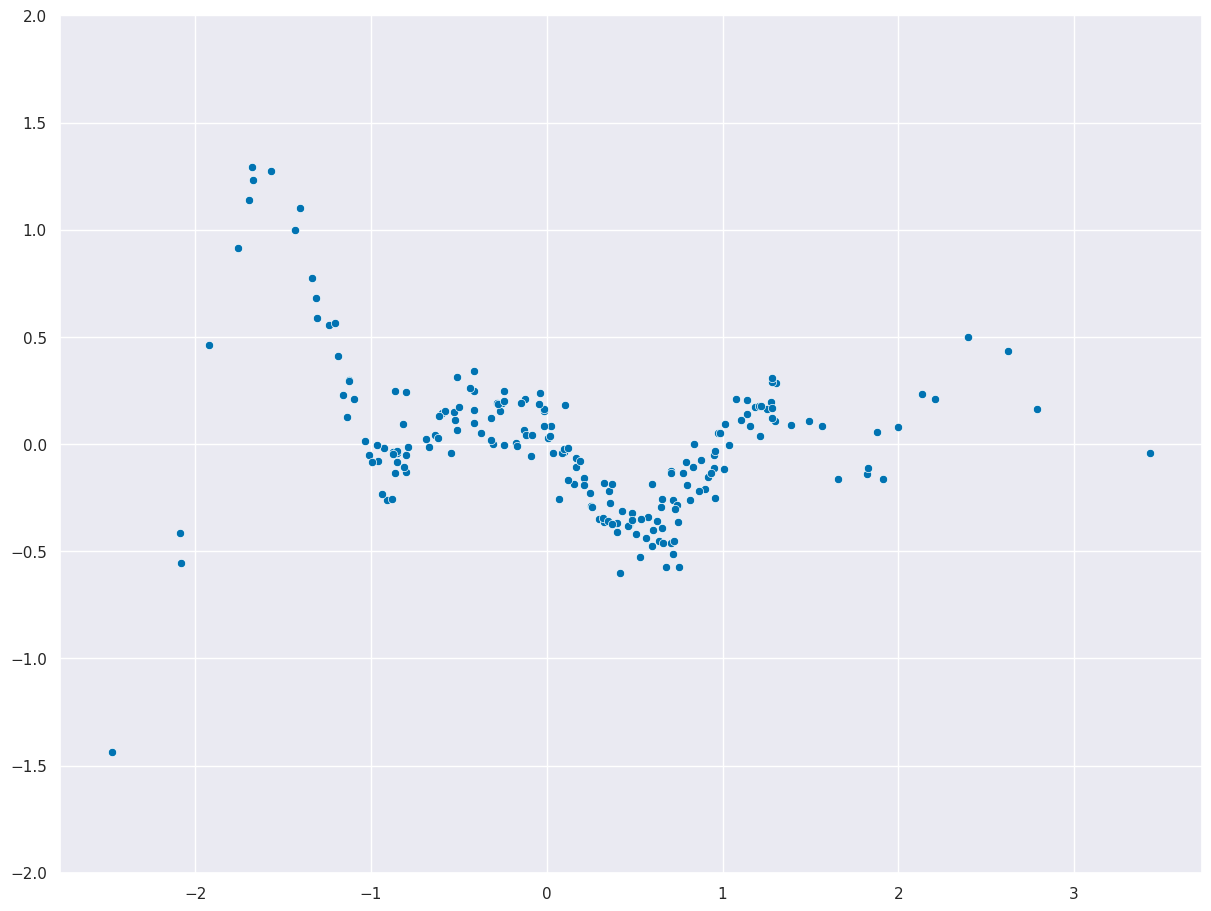

In [37]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax.set_ylim(-2., 2.);

Generate in-between dataset

In [38]:
X_inbtwn_train, y_inbtwn_train = generate_dataset(n_train, obs_var, in_between=True)

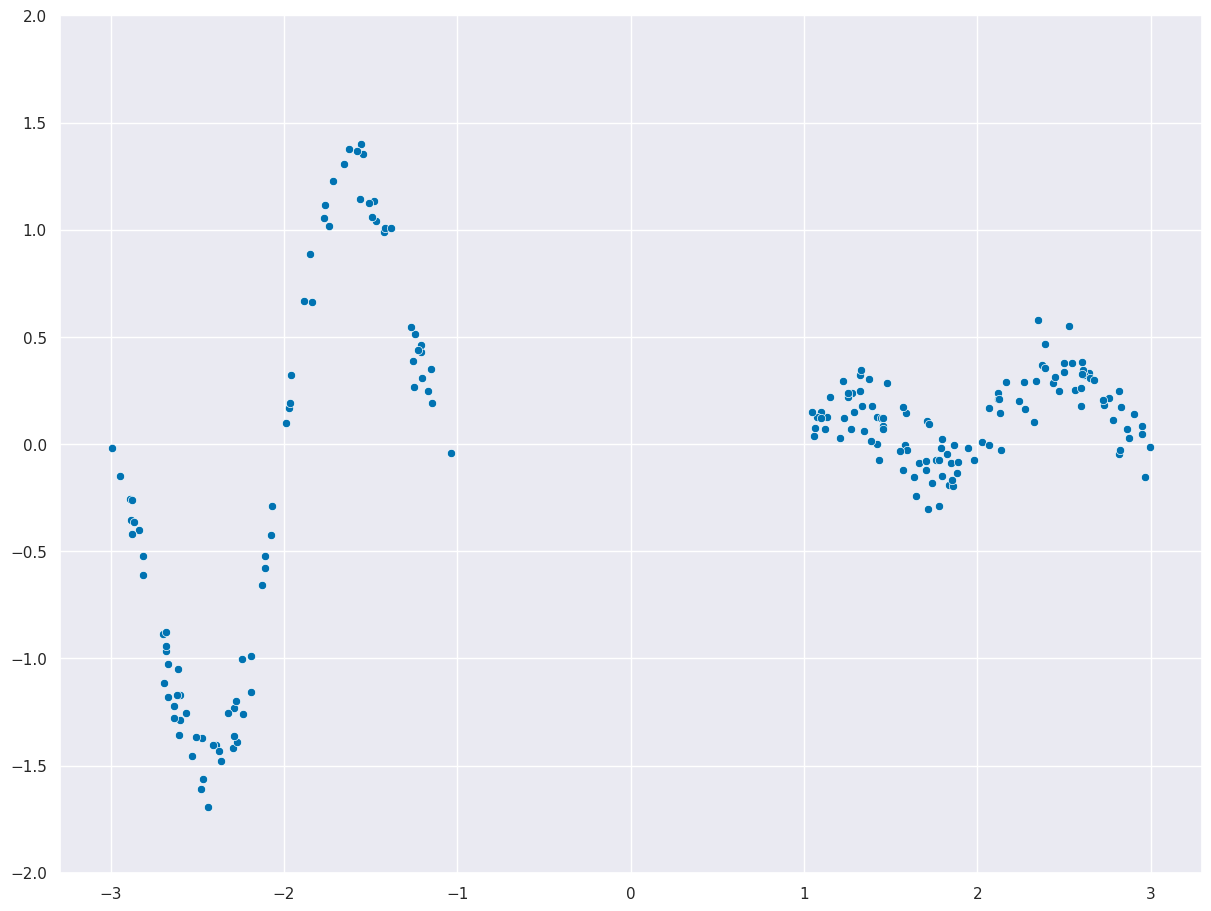

In [39]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax.set_ylim(-2., 2.);

Define an MLP model with separate features and output components to enable intermediate result extraction.

In [40]:
class MLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.penultimate = Features(self.features)
        self.output = Output()

    def __call__(self, x):
        x = self.penultimate(x)
        x = self.output(x)
        return x

class Features(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.gelu(nn.Dense(feat)(x))
        return x

class Output(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Dense(1)(x)

In [41]:
n_features = 100
features = [n_features] * 3
model = MLP(features=features)
params = model.init(jr.PRNGKey(0), jnp.ones((1,)))
flat_params, unflatten_fn = ravel_pytree(params)
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))
apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

# Extract penultimate layer results
get_features = lambda params, x: model.apply(
    unflatten_fn(params), jnp.atleast_1d(x), 
    method=lambda module, x: module.penultimate(jnp.atleast_1d(x))
)
print(flat_params.shape)

(20501,)


# 1. Neural Linear Model 

## 1.1 Point Estimates

### 1.1.1 Full Dataset

In [42]:
config = get_adamw_config(
    learning_rate=1e-3, weight_decay=1/(2*0.95*n_train), batch_size=32, num_epochs=500
)

In [43]:
@jit
def compute_loss_and_updates(state, X_batch, y_batch):
    def loss_fn(params):
        preds = vmap(state.apply_fn, (None, 0))(params, X_batch).squeeze()
        loss = jnp.mean(optax.l2_loss(preds, y_batch))
        return loss

    grad_fn = value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    return grads, loss

In [44]:
def fit(config, apply_fn, flat_params, n_train, X_train, y_train):
    # Initialize the optimizer
    tx = optax.adamw(learning_rate=config.learning_rate, weight_decay=config.weight_decay)
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)

    for epoch in range(1, config.num_epochs+1):
        # Keep track of the loss
        train_loss = []

        # Shuffle the data at the beginning of each epoch
        key = jr.PRNGKey(epoch)
        perm = jr.permutation(key, n_train)
        perm = perm[:(n_train//config.batch_size)*config.batch_size].reshape(
            (n_train//config.batch_size, config.batch_size)
        )

        for batch in perm:
            X_batch, y_batch = X_train[batch], y_train[batch]
            grads, loss = compute_loss_and_updates(opt_state, X_batch, y_batch)
            opt_state = opt_state.apply_gradients(grads=grads)
            train_loss.append(loss)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch} - loss: {jnp.mean(jnp.array(train_loss))}")
    
    return opt_state

In [45]:
config = get_adamw_config(
    learning_rate=1e-3, weight_decay=1/(2*0.95*n_train), batch_size=32, num_epochs=500
)

In [46]:
trained_state = fit(config, apply_fn, flat_params, n_train, X_train, y_train)

Epoch 20 - loss: 0.03106614015996456
Epoch 40 - loss: 0.018790654838085175
Epoch 60 - loss: 0.010219831950962543
Epoch 80 - loss: 0.007146984338760376
Epoch 100 - loss: 0.007653612643480301
Epoch 120 - loss: 0.007785381283611059
Epoch 140 - loss: 0.006488095037639141
Epoch 160 - loss: 0.005925497971475124
Epoch 180 - loss: 0.006972478702664375
Epoch 200 - loss: 0.006455711089074612
Epoch 220 - loss: 0.00599332433193922
Epoch 240 - loss: 0.00565789919346571
Epoch 260 - loss: 0.006004392169415951
Epoch 280 - loss: 0.006444124039262533
Epoch 300 - loss: 0.005853074602782726
Epoch 320 - loss: 0.0055977883748710155
Epoch 340 - loss: 0.005629136227071285
Epoch 360 - loss: 0.0056950743310153484
Epoch 380 - loss: 0.005152665078639984
Epoch 400 - loss: 0.005949626676738262
Epoch 420 - loss: 0.005870593711733818
Epoch 440 - loss: 0.0056205932050943375
Epoch 460 - loss: 0.005750369280576706
Epoch 480 - loss: 0.0052879187278449535
Epoch 500 - loss: 0.005561299622058868


In [47]:
# Evaluate trained model on grid
y_preds = vmap(apply_fn, (None, 0))(trained_state.params, X_grid).squeeze()

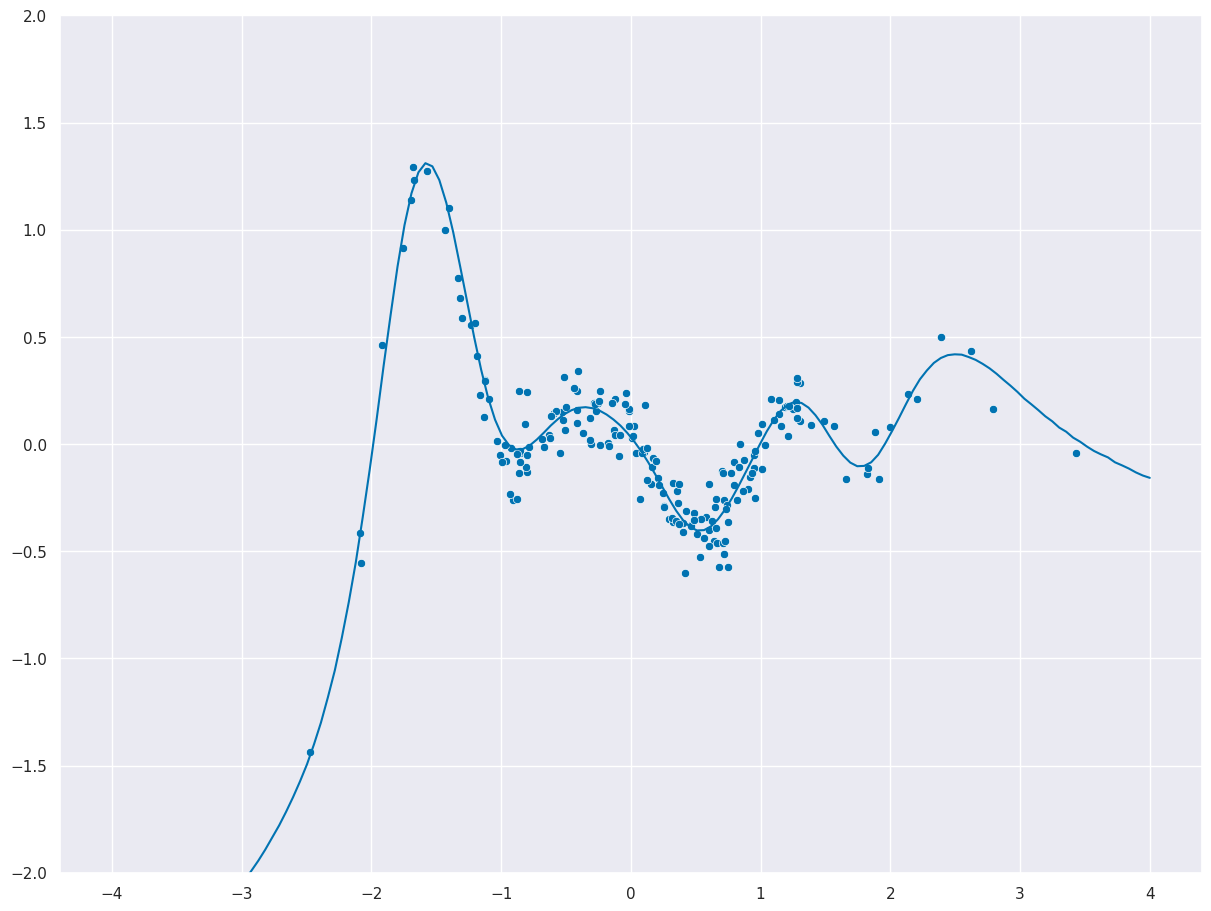

In [48]:
# Visualize the point-estimate results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_preds, ax=ax)
ax.set_ylim(-2., 2.);

### 1.1.2 In-Between Dataset

In [49]:
# Train on in-between data
trained_inbtwn_state = fit(config, apply_fn, flat_params, n_train, X_inbtwn_train, y_inbtwn_train)

Epoch 20 - loss: 0.0899842232465744
Epoch 40 - loss: 0.07830332219600677
Epoch 60 - loss: 0.04280129075050354
Epoch 80 - loss: 0.025341970846056938
Epoch 100 - loss: 0.012075534090399742
Epoch 120 - loss: 0.010963707230985165
Epoch 140 - loss: 0.007842752151191235
Epoch 160 - loss: 0.007509828545153141
Epoch 180 - loss: 0.006703550927340984
Epoch 200 - loss: 0.006246800534427166
Epoch 220 - loss: 0.005735007580369711
Epoch 240 - loss: 0.0060664452612400055
Epoch 260 - loss: 0.006485834717750549
Epoch 280 - loss: 0.005839355289936066
Epoch 300 - loss: 0.005616884678602219
Epoch 320 - loss: 0.005751796066761017
Epoch 340 - loss: 0.005388583987951279
Epoch 360 - loss: 0.0054585738107562065
Epoch 380 - loss: 0.007042359560728073
Epoch 400 - loss: 0.005424169823527336
Epoch 420 - loss: 0.004918520804494619
Epoch 440 - loss: 0.006498423870652914
Epoch 460 - loss: 0.005188392009586096
Epoch 480 - loss: 0.004920261446386576
Epoch 500 - loss: 0.007388231810182333


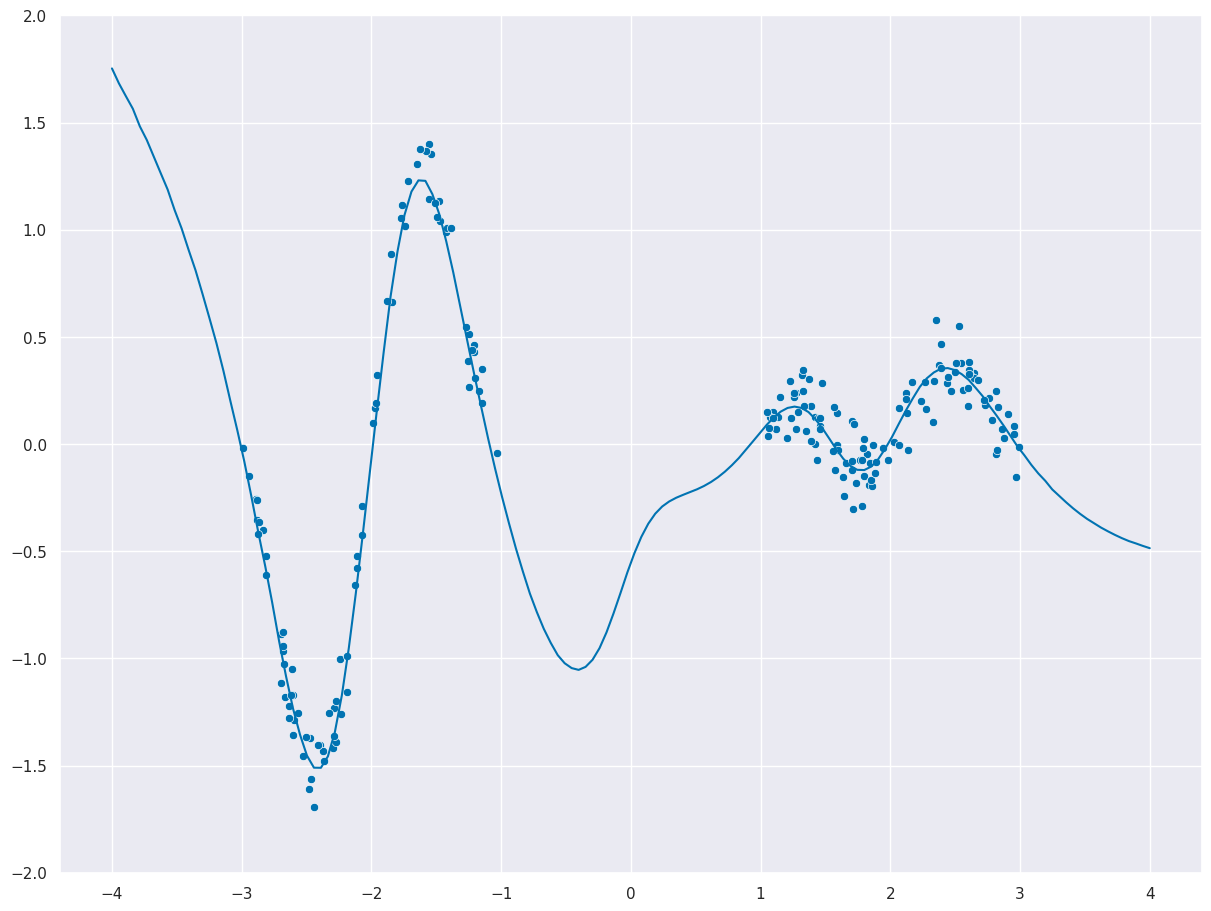

In [50]:
# Evaluate trained model on grid
y_inbtwn_preds = vmap(apply_fn, (None, 0))(trained_inbtwn_state.params, X_grid).squeeze()

# Visualize the point-estimate results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_inbtwn_preds, ax=ax)
ax.set_ylim(-2., 2.);

## 1.2 Uncertainty Estimates

### 1.2.1 Full Dataset

In [51]:
# Compute penultimate layer results
phi_train = vmap(get_features, (None, 0))(trained_state.params, X_train)
phi_test = vmap(get_features, (None, 0))(trained_state.params, X_grid)
print(phi_train.shape, phi_test.shape)

(200, 100) (150, 100)


To compute the posterior covariance, we treat the final layer as a Bayesian linear regression model and analytically solve for $\phi(x)^{\top}\left(\sigma^{-2}\phi(X_{\text{train}})^{⊤} \phi(X_{\text{train}}) + \mathbf{I}\right)^{-1}\phi(x)$.

In [52]:
post_cov = phi_test @ jnp.linalg.pinv(phi_train.T @ phi_train/obs_var + jnp.eye(n_features)) @ phi_test.T
post_cov += 1e-2 * jnp.eye(len(post_cov)) # to ensure positive definiteness
post_std = jnp.sqrt(jnp.diag(post_cov))

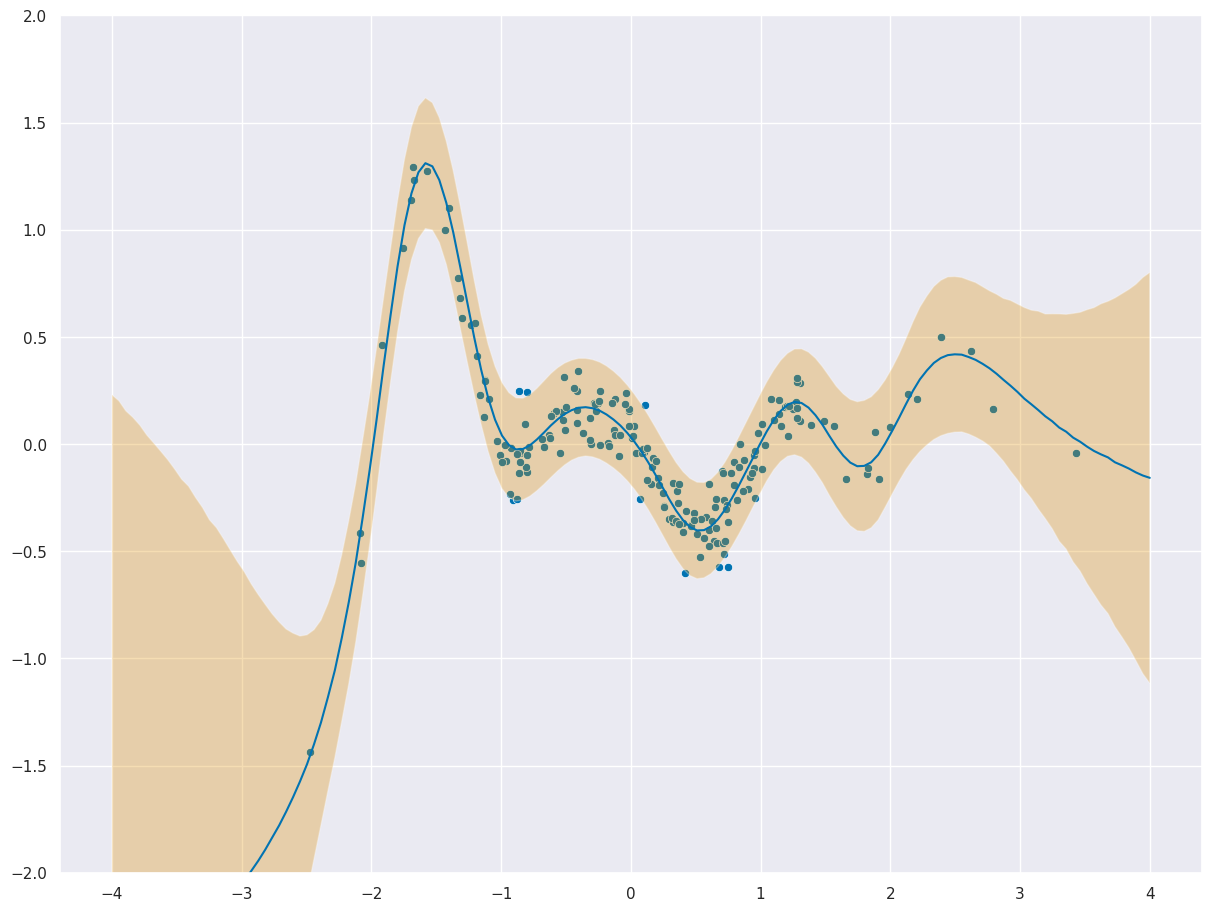

In [53]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_preds, ax=ax)
ax.fill_between(
    X_grid, y_preds - 1.96*post_std, y_preds + 1.96*post_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 1.2.2 In-Between Dataset

In [54]:
# Compute penultimate layer results
phi_inbtwn_train = vmap(get_features, (None, 0))(trained_inbtwn_state.params, X_inbtwn_train)
phi_inbtwn_test = vmap(get_features, (None, 0))(trained_inbtwn_state.params, X_grid)
print(phi_inbtwn_train.shape, phi_inbtwn_test.shape)

(200, 100) (150, 100)


In [55]:
post_inbtwn_cov = phi_inbtwn_test @ jnp.linalg.pinv(phi_inbtwn_train.T @ phi_inbtwn_train/obs_var + jnp.eye(n_features)) @ phi_inbtwn_test.T
post_inbtwn_cov += 1e-2 * jnp.eye(len(post_inbtwn_cov)) # to ensure positive definiteness
post_inbtwn_std = jnp.sqrt(jnp.diag(post_inbtwn_cov))

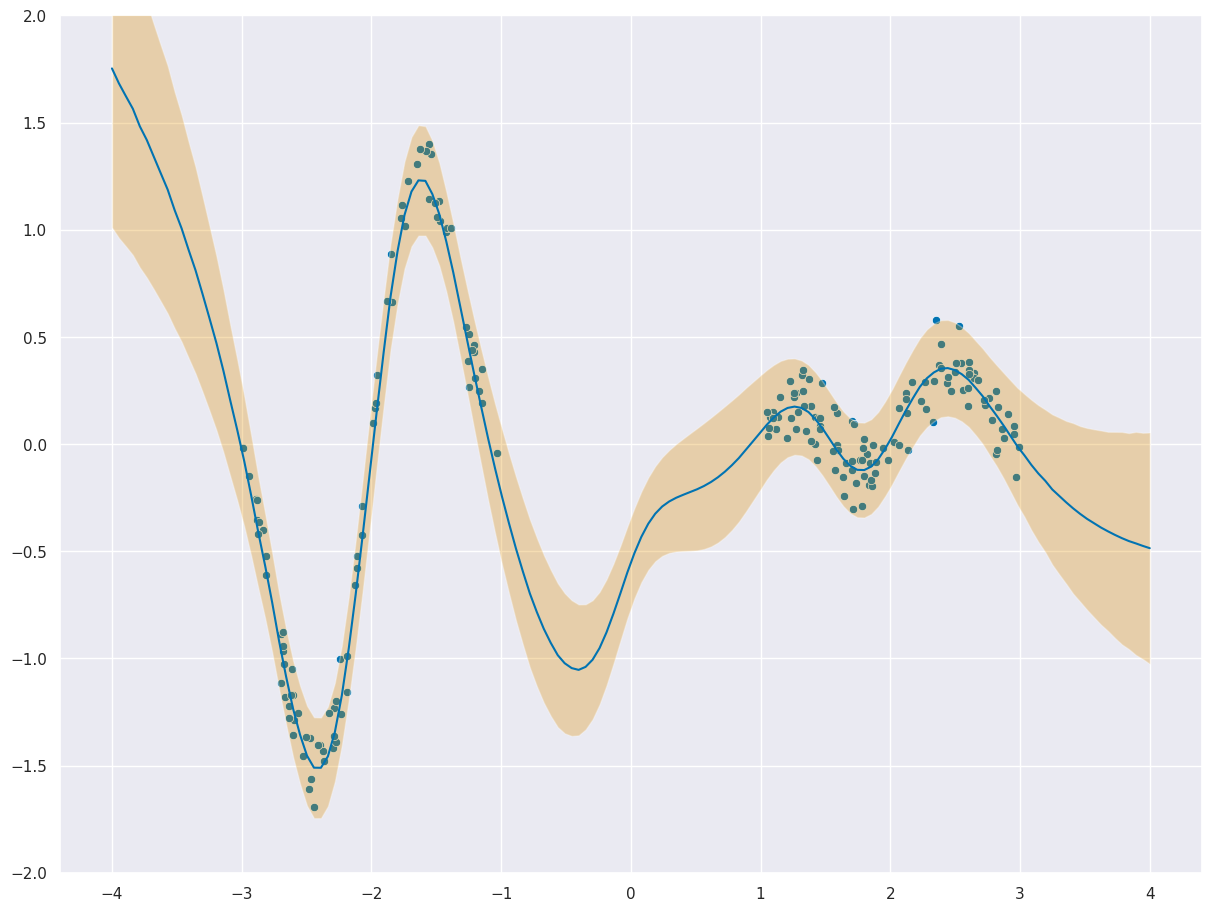

In [56]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_inbtwn_preds, ax=ax)
ax.fill_between(
    X_grid, y_inbtwn_preds - 1.96*post_inbtwn_std, y_inbtwn_preds + 1.96*post_inbtwn_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

## 1.3 Posterior Predictive Sampling

### 1.3.1 Full Dataset

In [57]:
# Take 100 samples from the posterior predictive distribution
f_samples = MVN(loc=y_preds, covariance_matrix=post_cov).sample((100,), seed=jr.PRNGKey(0))

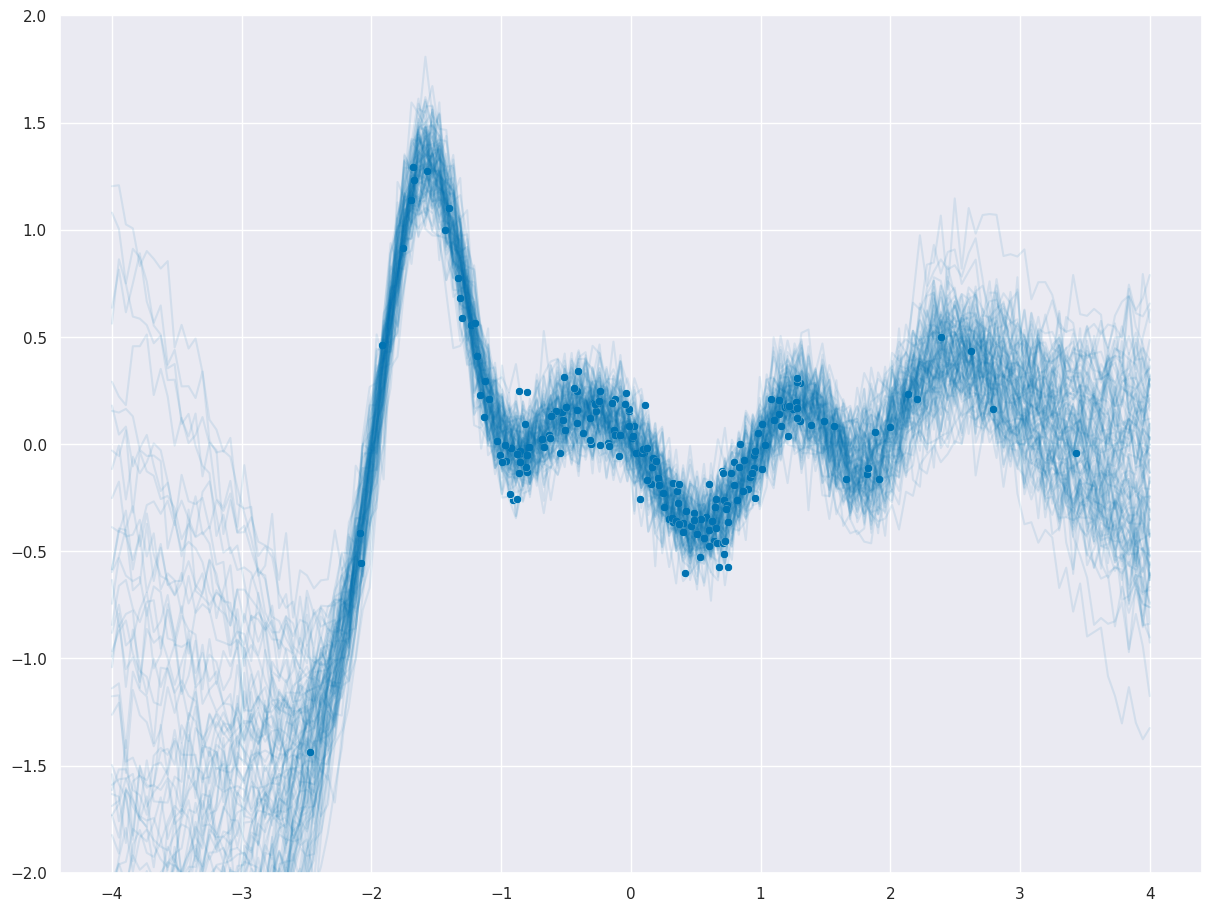

In [58]:
# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
for func in f_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

### 1.3.2 In-Between Dataset

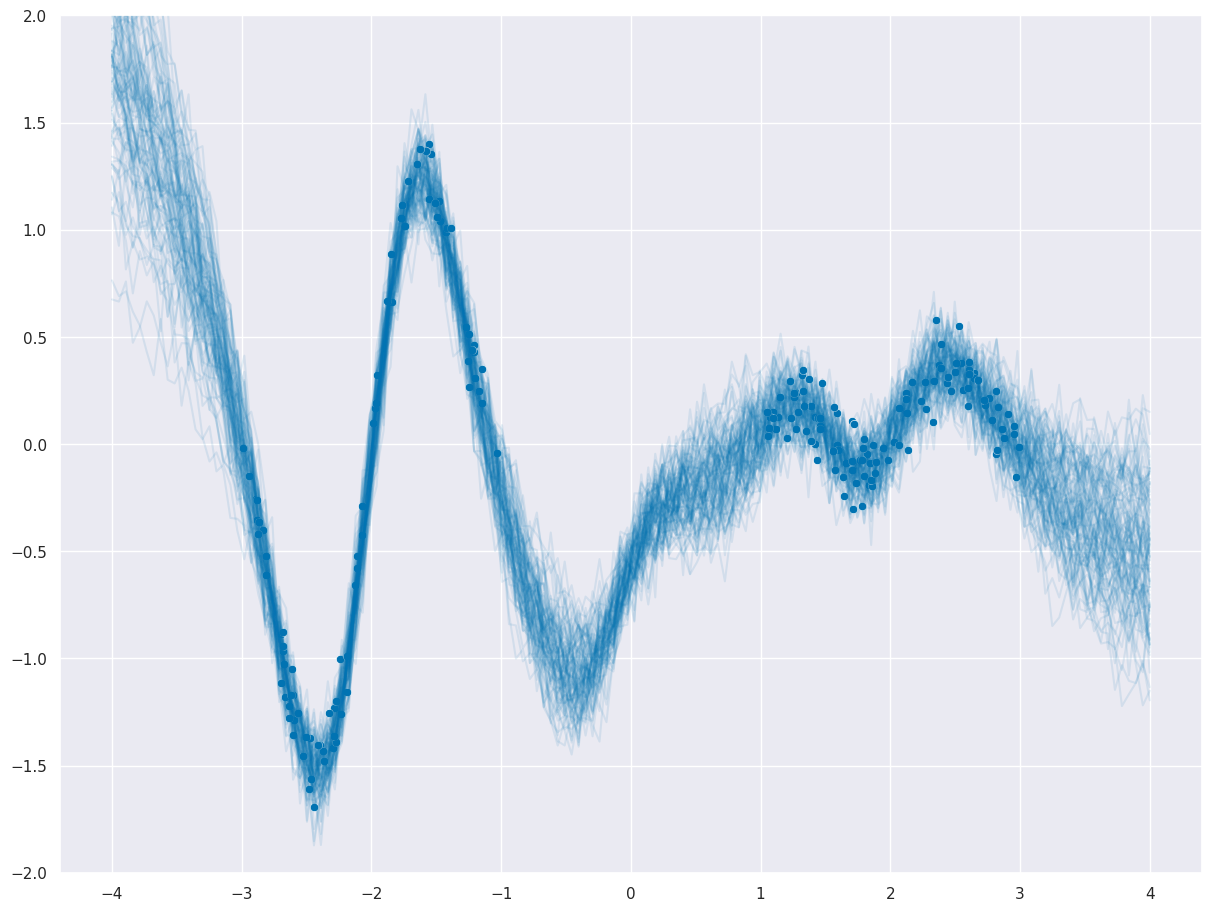

In [59]:
# Take 100 samples from the posterior predictive distribution
f_inbtwn_samples = MVN(loc=y_inbtwn_preds, covariance_matrix=post_inbtwn_cov).sample((100,), seed=jr.PRNGKey(0))

# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
for func in f_inbtwn_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

# 2. ORFit

In [57]:
# Initialize orfit estimator
model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=None,
    dynamics_weights=None,
    dynamics_covariance=None,
    emission_mean_function=apply_fn,
    emission_cov_function = lambda w, x: None,
)
orfit_params1 = LoFiParams(
    memory_size=n_train,
)
orfit_params2 = LoFiParams(
    memory_size=32,
)

estimator = RebayesLoFi(model_params, orfit_params1, method='orfit')
estimator2 = RebayesLoFi(model_params, orfit_params2, method='orfit')

In [58]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

## 2.1 Full Dataset

### 2.1.1 Single-Pass

In [59]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_train, y_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 2247.02it/s]


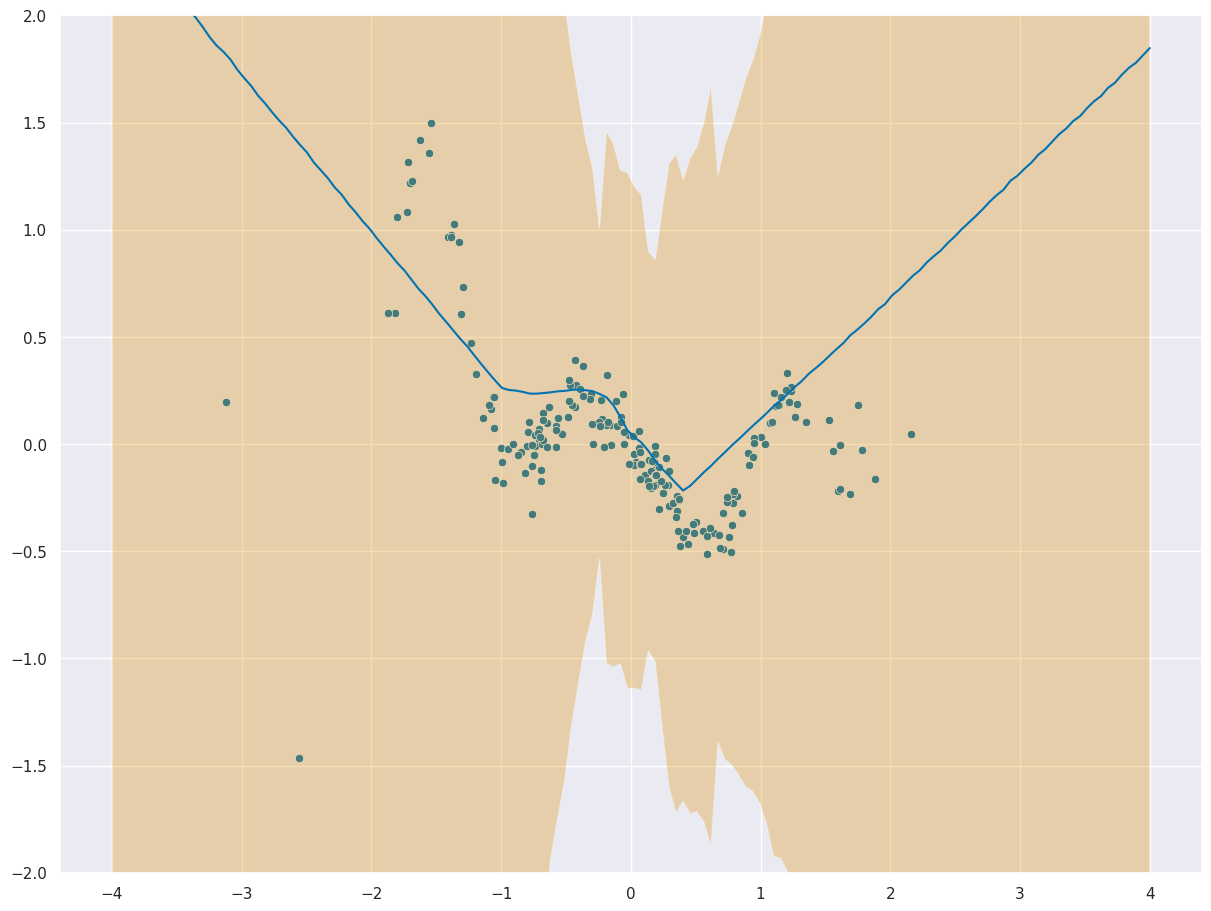

In [60]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

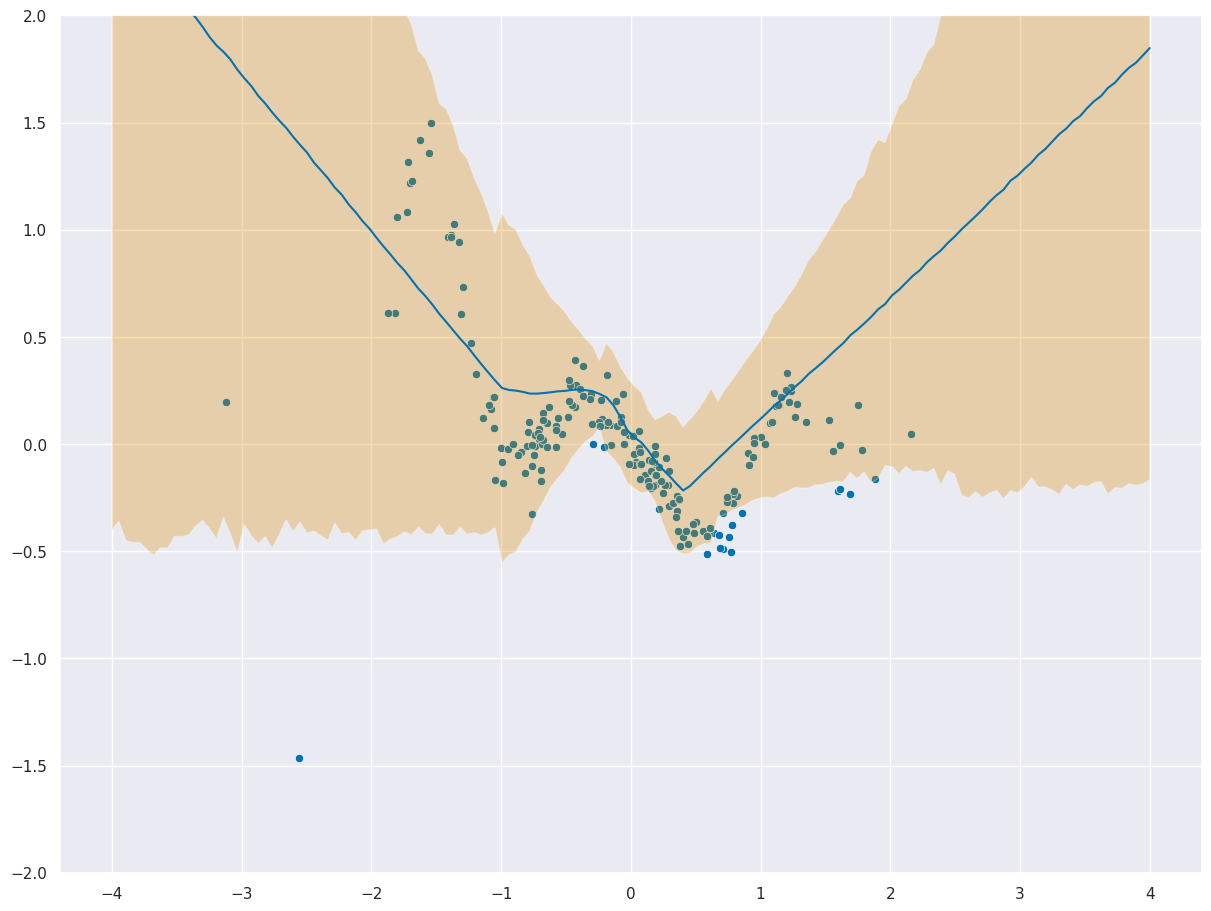

In [61]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

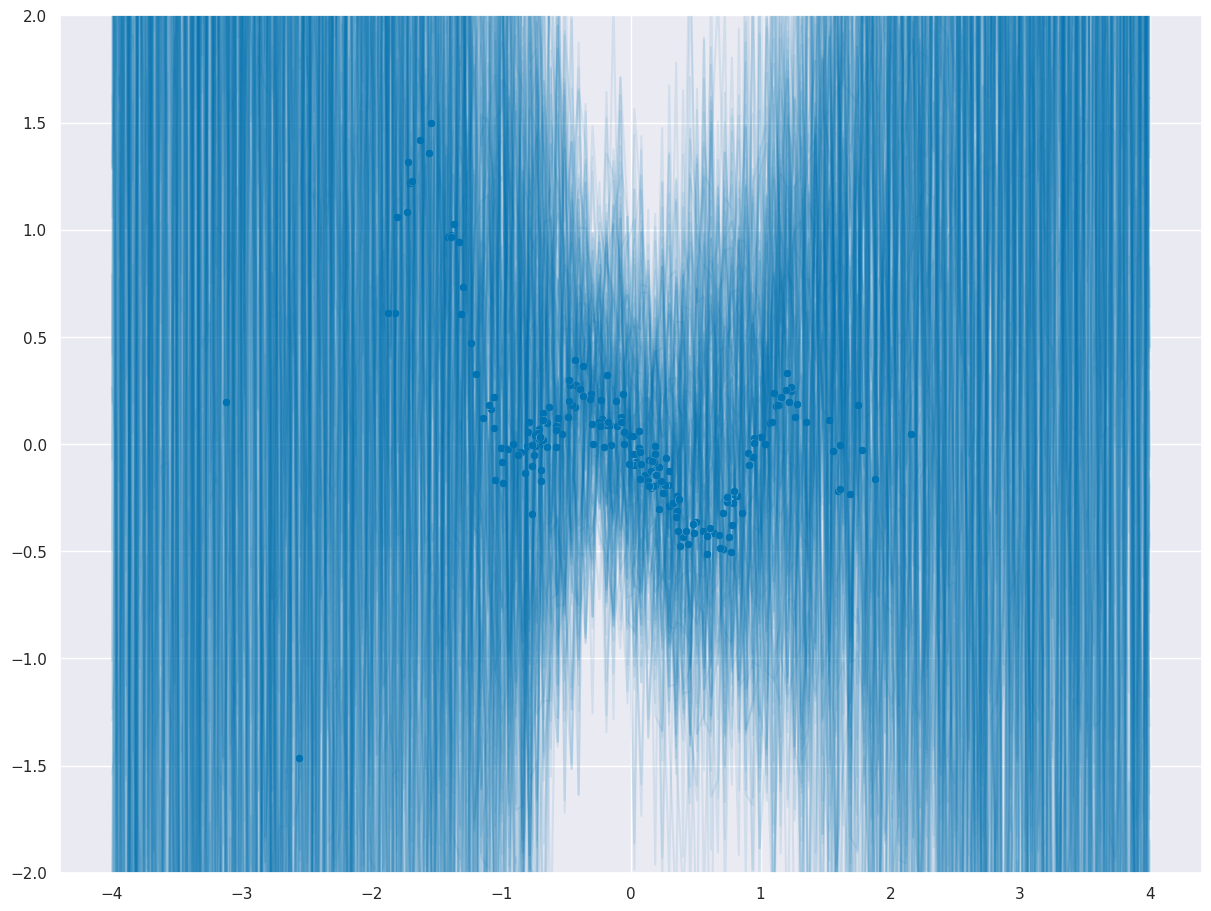

In [62]:
# Take 100 samples from the posterior predictive distribution
f_samples = MVN(loc=pred_mean, covariance_matrix=pred_cov).sample((100,), seed=jr.PRNGKey(0))

# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
for func in f_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

## 2.1.2 Multiple Passes (n=50)

In [63]:
# 50 passes over the dataset
n_passes = 50
X_multiple_train, y_multiple_train = jnp.tile(X_train, n_passes), jnp.tile(y_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [64]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:03<00:00, 3134.22it/s]


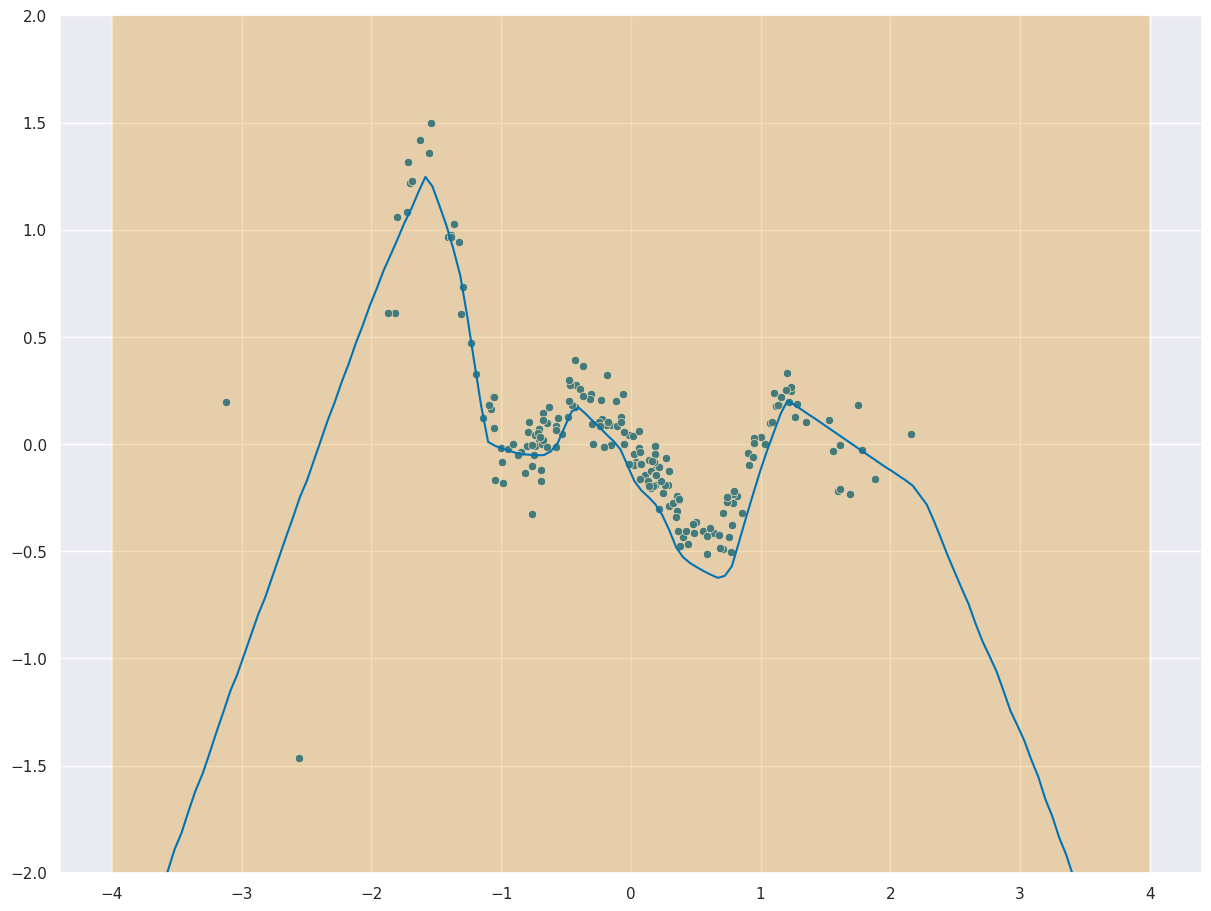

In [65]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

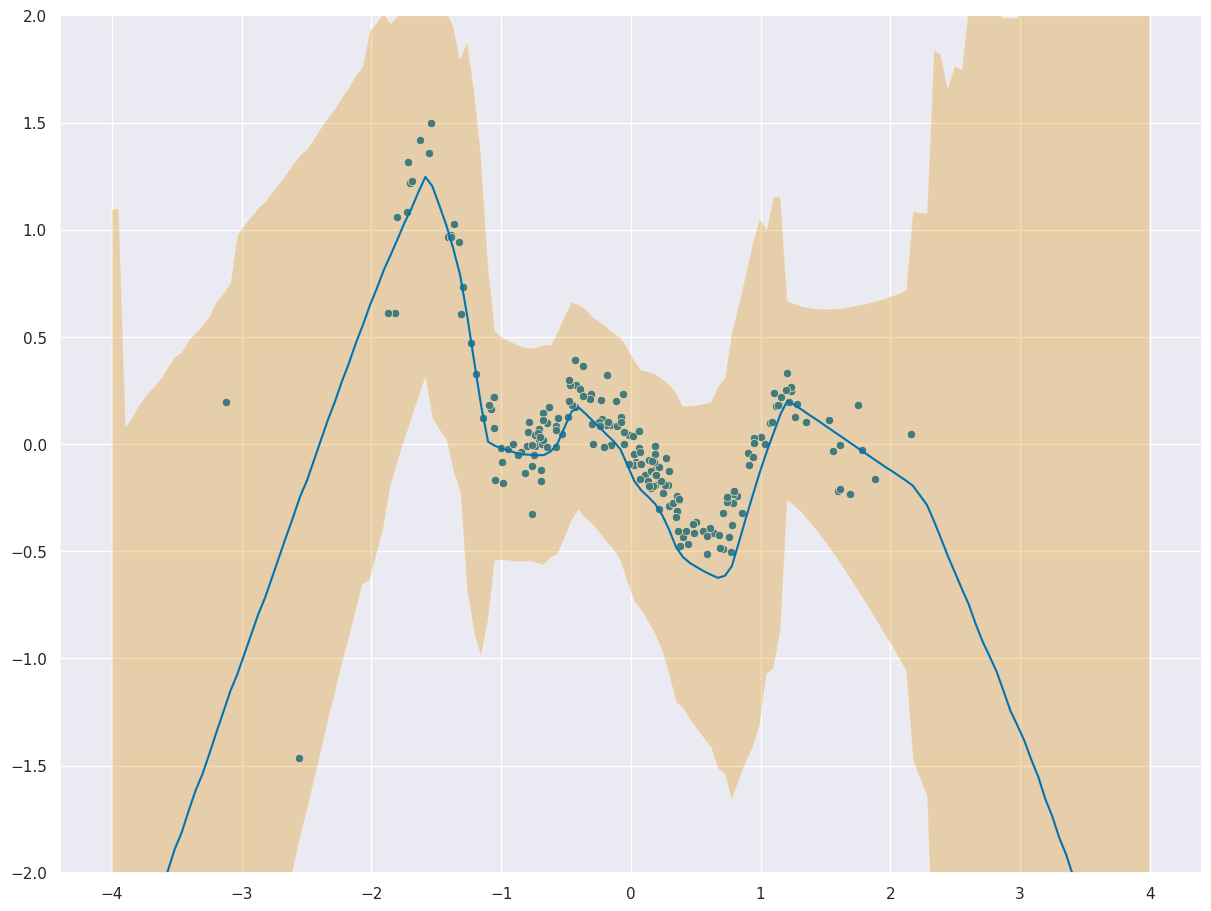

In [66]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

## 2.1.3 Multiple Passes (n=500)

In [67]:
# 500 passes over the dataset
n_passes = 500
X_multiple_train, y_multiple_train = jnp.tile(X_train, n_passes), jnp.tile(y_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [68]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 100,000 iterations: 100%|██████████| 100000/100000 [00:31<00:00, 3127.28it/s]


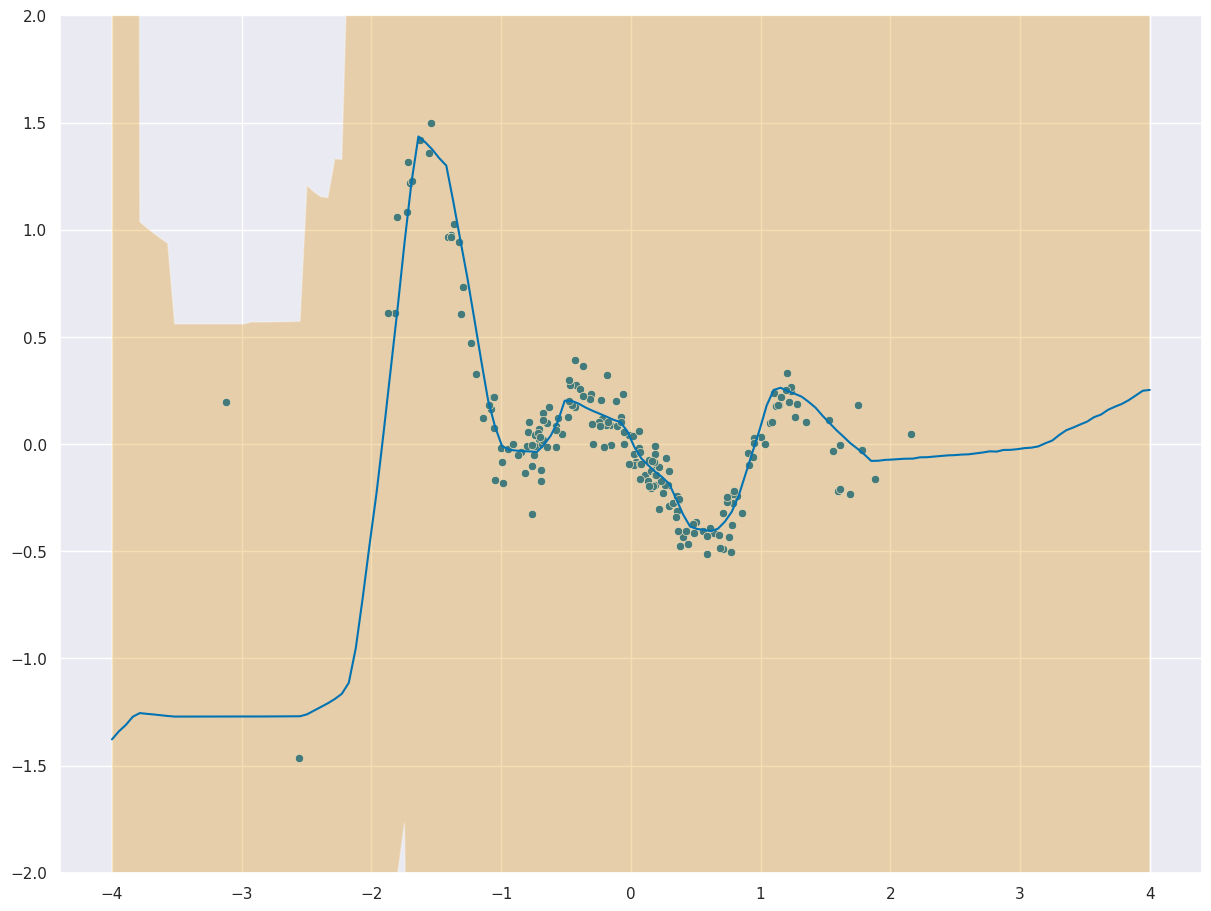

In [69]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

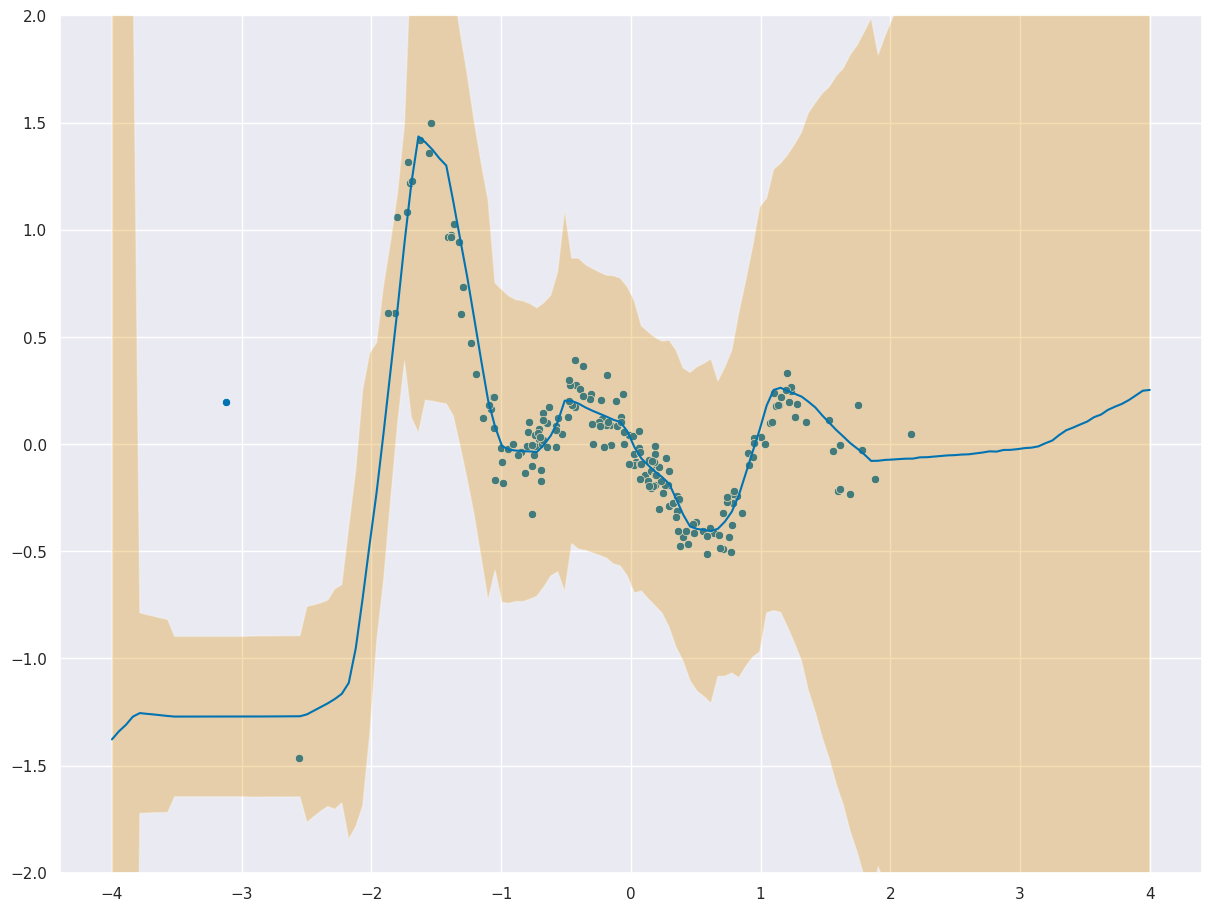

In [70]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

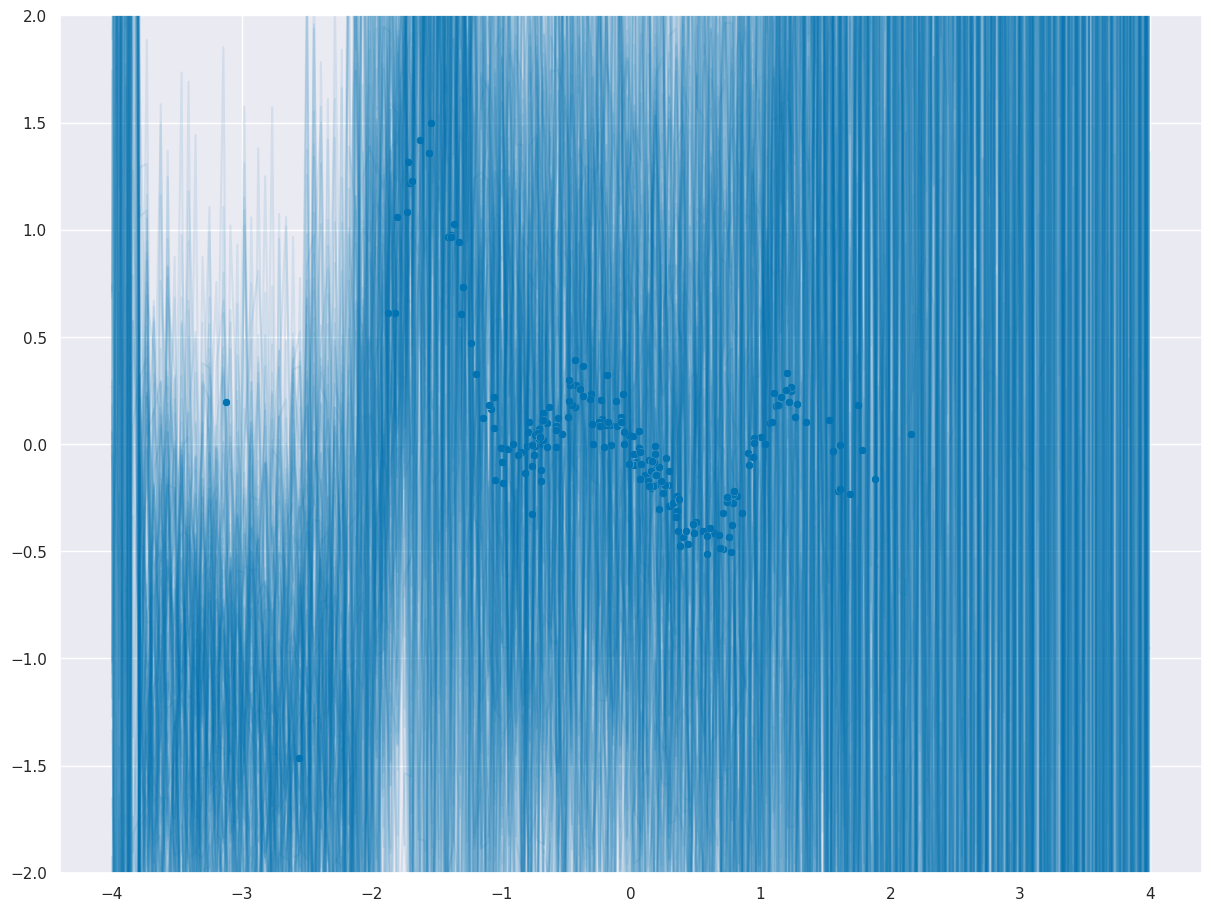

In [71]:
# Take 100 samples from the posterior predictive distribution
f_samples = MVN(loc=pred_mean, covariance_matrix=pred_cov).sample((100,), seed=jr.PRNGKey(0))

# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
for func in f_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

## 2.2 In-Between Dataset

### 2.2.1 Single-Pass

In [72]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_inbtwn_train, y_inbtwn_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 2113.76it/s]


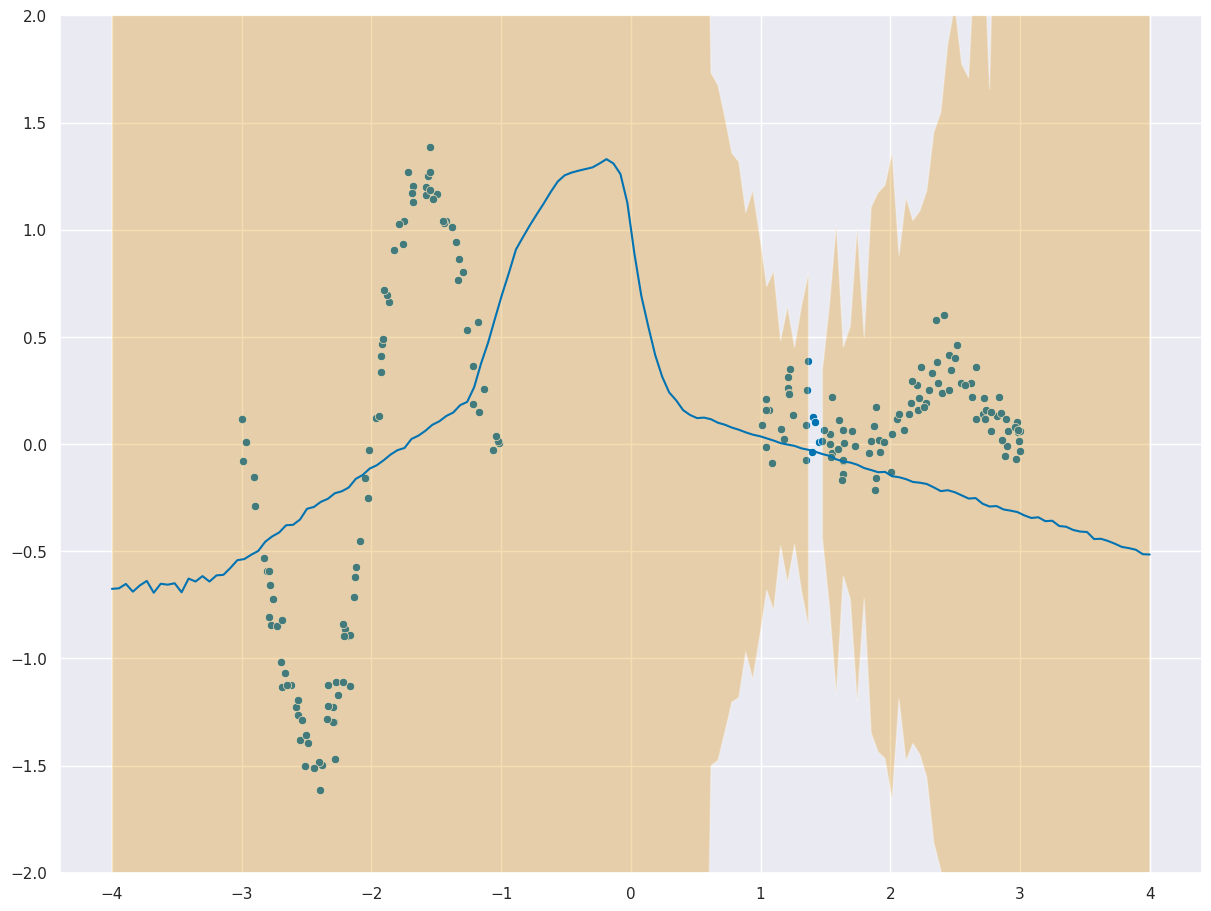

In [73]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

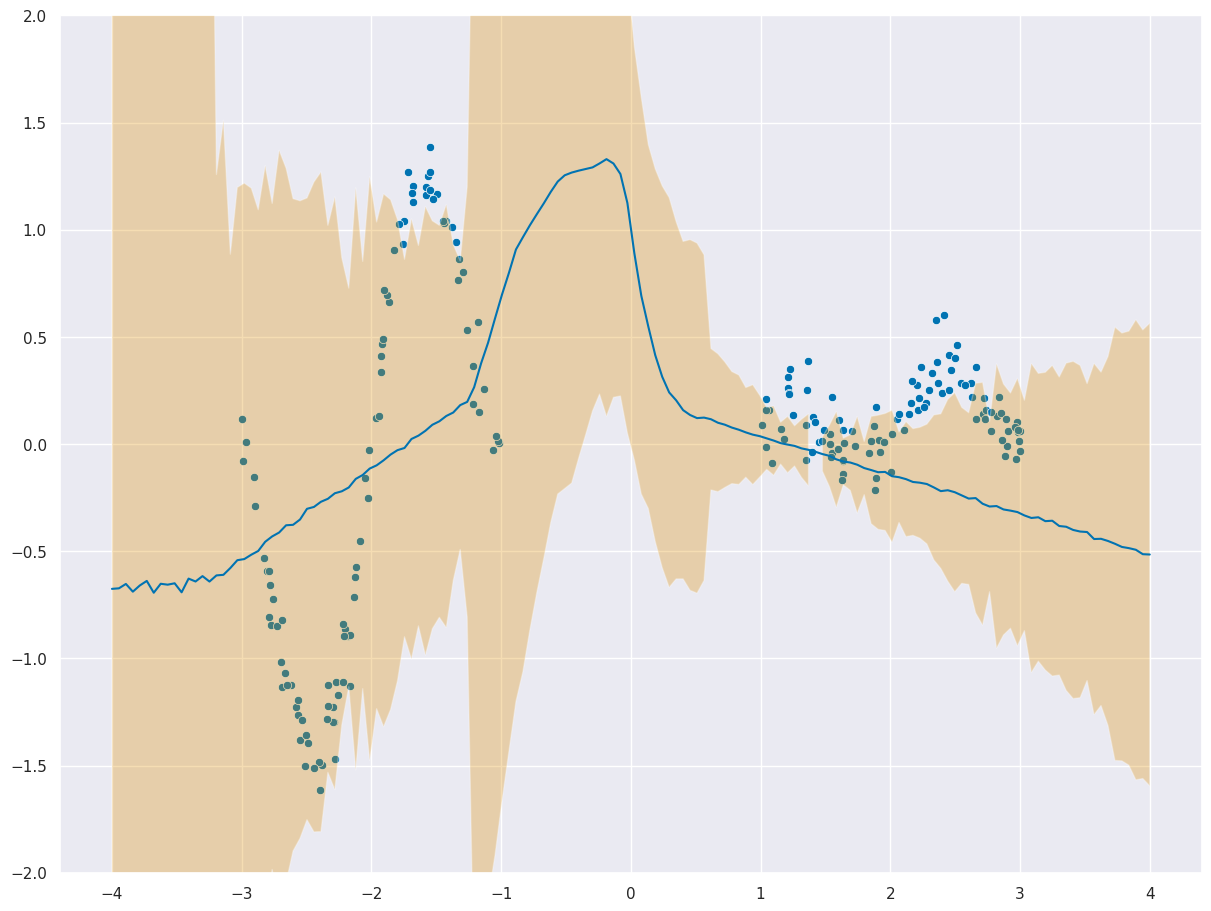

In [74]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 2.2.2 Multiple Passes (n=50)

In [75]:
# 50 passes over the dataset
n_passes = 50
X_multiple_train, y_multiple_train = jnp.tile(X_inbtwn_train, n_passes), jnp.tile(y_inbtwn_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [76]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:03<00:00, 3129.99it/s]


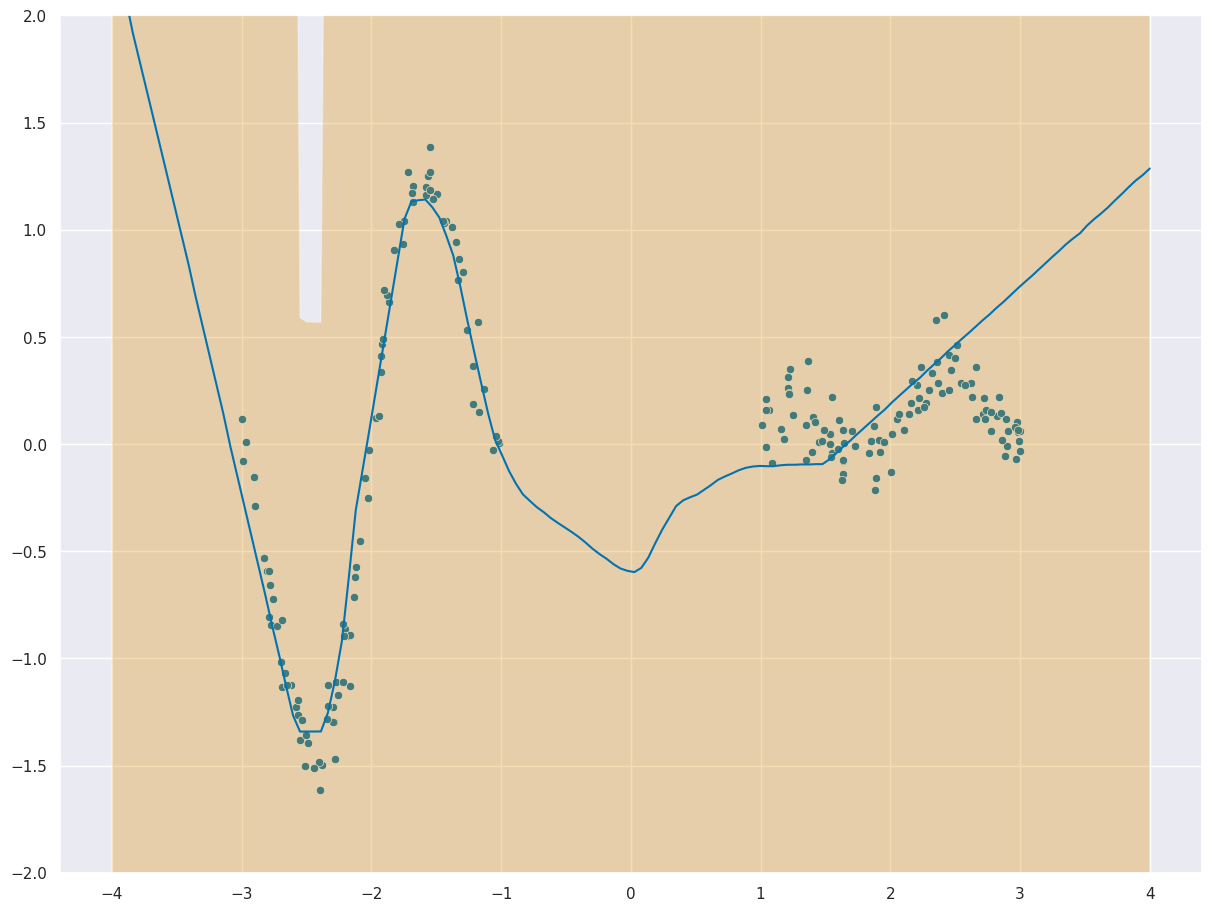

In [77]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

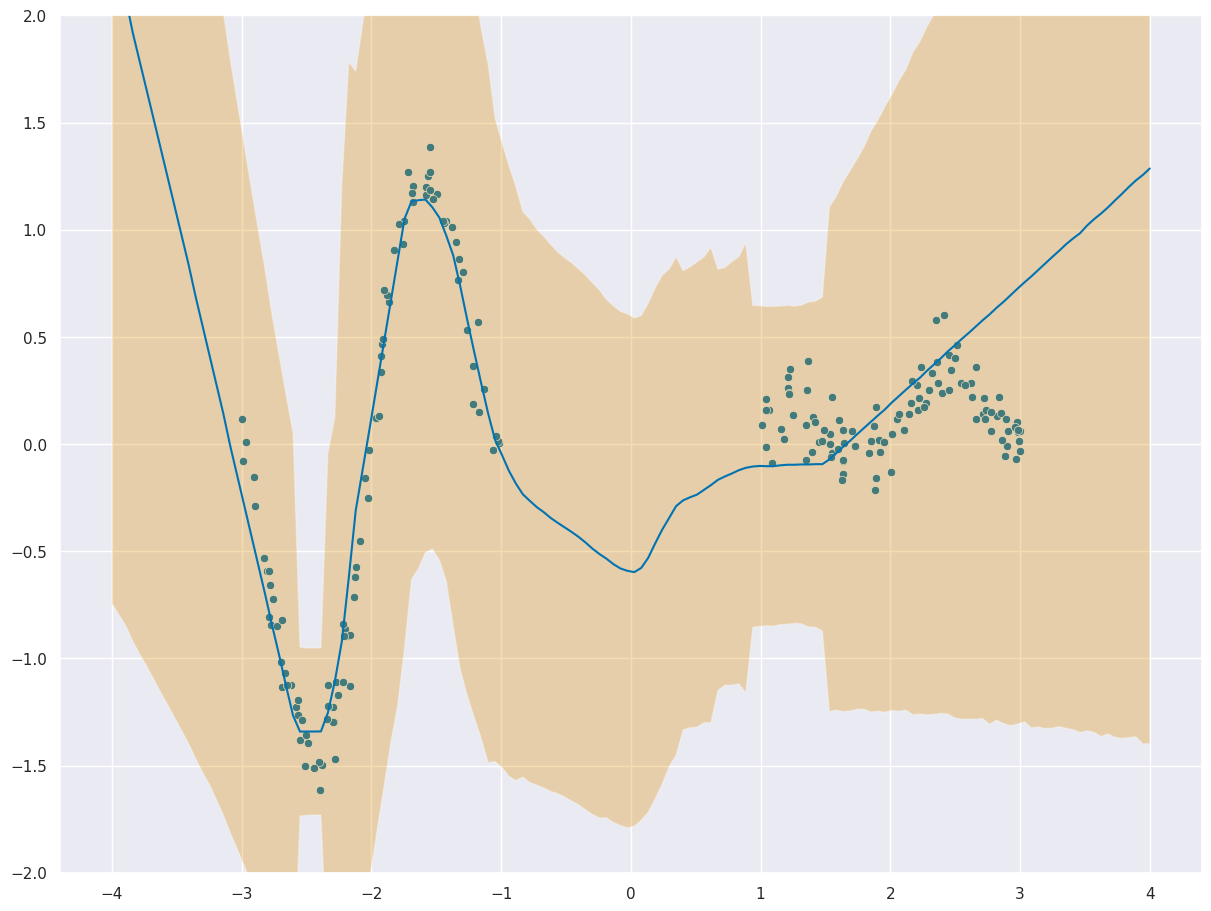

In [78]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 2.2.3 Multiple Passes (n=500)

In [79]:
# 500 passes over the dataset
n_passes = 500
X_multiple_train, y_multiple_train = jnp.tile(X_inbtwn_train, n_passes), jnp.tile(y_inbtwn_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [80]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 100,000 iterations: 100%|██████████| 100000/100000 [00:31<00:00, 3127.24it/s]


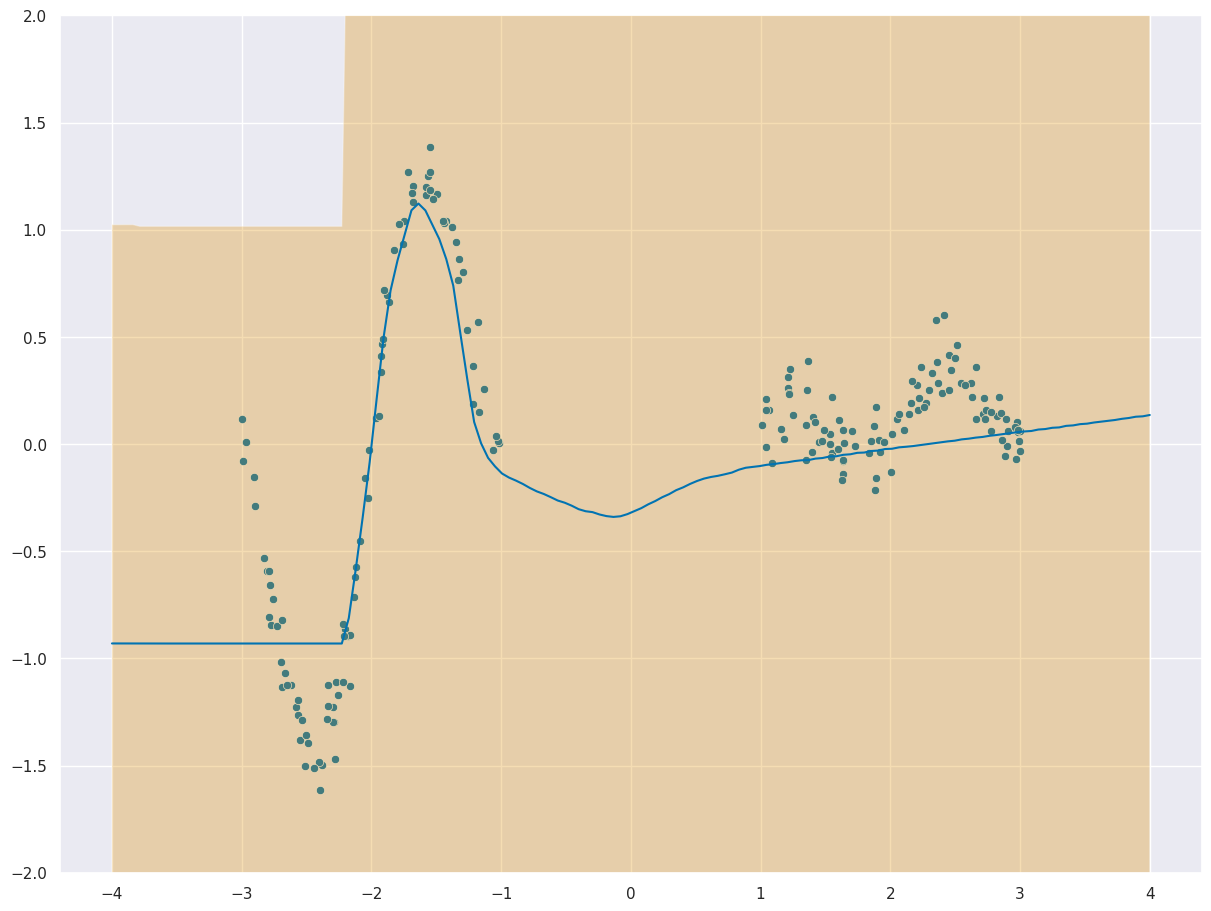

In [81]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

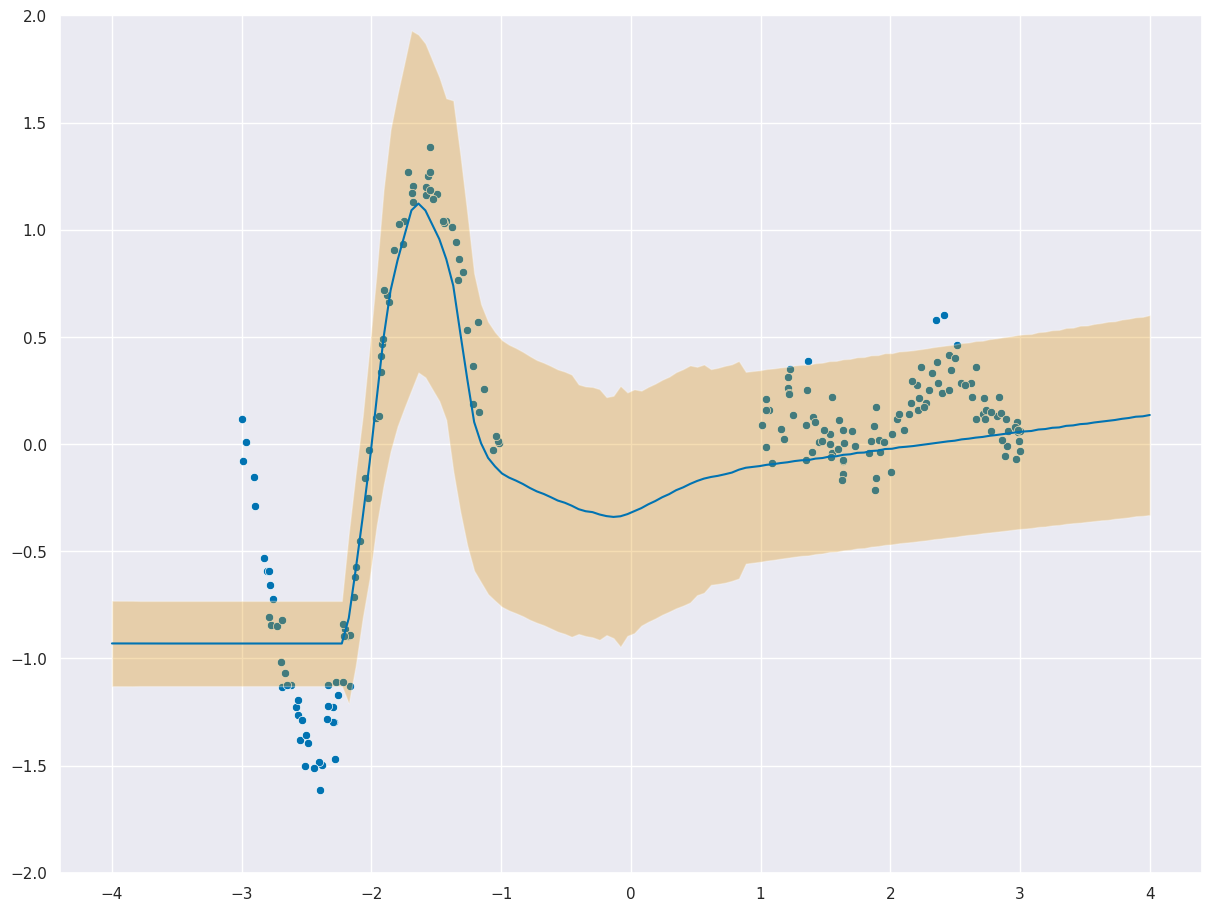

In [82]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.2*pred_std, pred_mean + 0.2*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

# 3. LoFi

## 3.1 Full Dataset

### 3.1.1 Hyperparameter Tuning

In [63]:
def lofi_opt_fn(log_init_cov, log_dynamics_cov, log_alpha):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov).item(),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: None,
        adaptive_emission_cov=True,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    lofi_params = LoFiParams(
        memory_size=n_train,
    )
    estimator = RebayesLoFi(model_params, lofi_params, method='full_svd_lofi')

    bel, _ = estimator.scan(X_train, y_train, progress_bar=False)

    # Train RMSE
    y_pred = vmap(apply_fn, (None, 0))(bel.mean, X_train).squeeze()
    rmse = jnp.sqrt(((y_pred.ravel() - y_train)**2).mean())
    if jnp.isnan(rmse):
        return -1e3

    return max(-rmse, -1e3)

In [64]:
lofi_optimizer = BayesianOptimization(
    f=lofi_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [65]:
lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -0.3572   | -4.502    | -5.136    | -5.08     |
| 2         | -0.3498   | -0.7577   | -1.965    | -4.877    |
| 3         | -0.3996   | -0.4712   | -1.242    | -1.086    |
| 4         | -0.3387   | -0.9802   | -1.781    | -2.584    |
| 5         | -0.3403   | -6.495    | -0.6927   | -4.543    |
| 6         | -0.3073   | -2.768    | -5.758    | -0.5459   |
| 7         | -0.3079   | -3.913    | -0.265    | -3.086    |
| 8         | -0.3524   | -0.614    | -4.893    | -4.953    |
| 9         | -0.2948   | -6.327    | -5.724    | -1.922    |
| 10        | -0.295    | -5.439    | -3.356    | -1.281    |
| 11        | -0.3247   | -5.626    | -1.042    | -3.984    |
| 12        | -0.3209   | -1.37     | -2.162    | -0.8755   |
| 13        | -0.3028   | -3.768    | -0.4063   | -2.887    |
| 14        | -0.3684   | -1.604    | -2.529    | -5.94     |
| 15    

In [66]:
# 'log_alpha': -7.0, 'log_dynamics_cov': -2.8563863943353445, 'log_init_cov': -2.073490501957211
print(lofi_optimizer.max)

{'target': -0.2901003956794739, 'params': {'log_alpha': -7.0, 'log_dynamics_cov': -2.8563863943353445, 'log_init_cov': -2.073490501957211}}


### 3.1.2 Single Pass

In [67]:
model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, -2.073490501957211).item(),
    dynamics_weights=1.0,
    dynamics_covariance=jnp.power(10, -2.8563863943353445),
    emission_mean_function=apply_fn,
    emission_cov_function = lambda w, x: None,
    adaptive_emission_cov=True,
    dynamics_covariance_inflation_factor=jnp.power(10, -7.0)
)
lofi_params = LoFiParams(
    memory_size=n_train,
)
lofi_estimator = RebayesLoFi(model_params, lofi_params, method='full_svd_lofi')

In [68]:
# Run infinite-memory aov lofi
bel, _ = lofi_estimator.scan(X_train, y_train)

Running for 200 iterations:  80%|████████  | 160/200 [00:03<00:00, 40.22it/s]

In [69]:
bel

LoFiBel(mean=Array([-0.05258669,  0.03658307, -0.03886006, ...,  0.07231953,
        0.09256262, -0.0194557 ], dtype=float32), basis=Array([[ 1.4855248e-01,  2.3078106e-01,  6.7392057e-01, ...,
        -2.4554102e-02, -2.2061858e-02,  2.7358460e-03],
       [ 5.9714261e-02,  2.7426027e-02, -2.2517990e-02, ...,
         5.0389685e-02,  1.6739553e-02, -1.7604714e-02],
       [ 7.3010638e-02, -2.3946324e-02,  7.1546580e-03, ...,
        -4.4571619e-02, -5.2399796e-02, -3.7213236e-02],
       ...,
       [-5.6442830e-05,  2.6800143e-04,  1.0562157e-03, ...,
        -1.9442770e-03,  5.8420713e-04,  1.3207633e-03],
       [-1.9946356e-05,  3.6123605e-05,  1.5995267e-04, ...,
         7.4293173e-04, -3.9380087e-04,  1.8511144e-03],
       [-3.6909773e-03, -5.4883963e-05,  8.7216811e-04, ...,
         2.1313021e-03, -2.4770915e-03, -9.7787380e-04]], dtype=float32), sigma=Array([1.6444347e+02, 9.3049881e+01, 4.2840565e+01, 2.5177010e+01,
       1.8251595e+01, 1.5956293e+01, 1.2203586e+01, 1.172

In [ ]:
lofi_ppd = lofi_estimator.

In [110]:
# Compute posterior predictive moments
lofi_ppd = lambda x: lofi_posterior_predictive_moments(
    apply_fn, 
    jnp.power(10, -3.1357690848643034).item(), 
    x, 
    bel.mean, 
    bel.basis, 
    bel.sigma
)

pred_mean, pred_cov = vmap(lofi_ppd)(X_grid)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

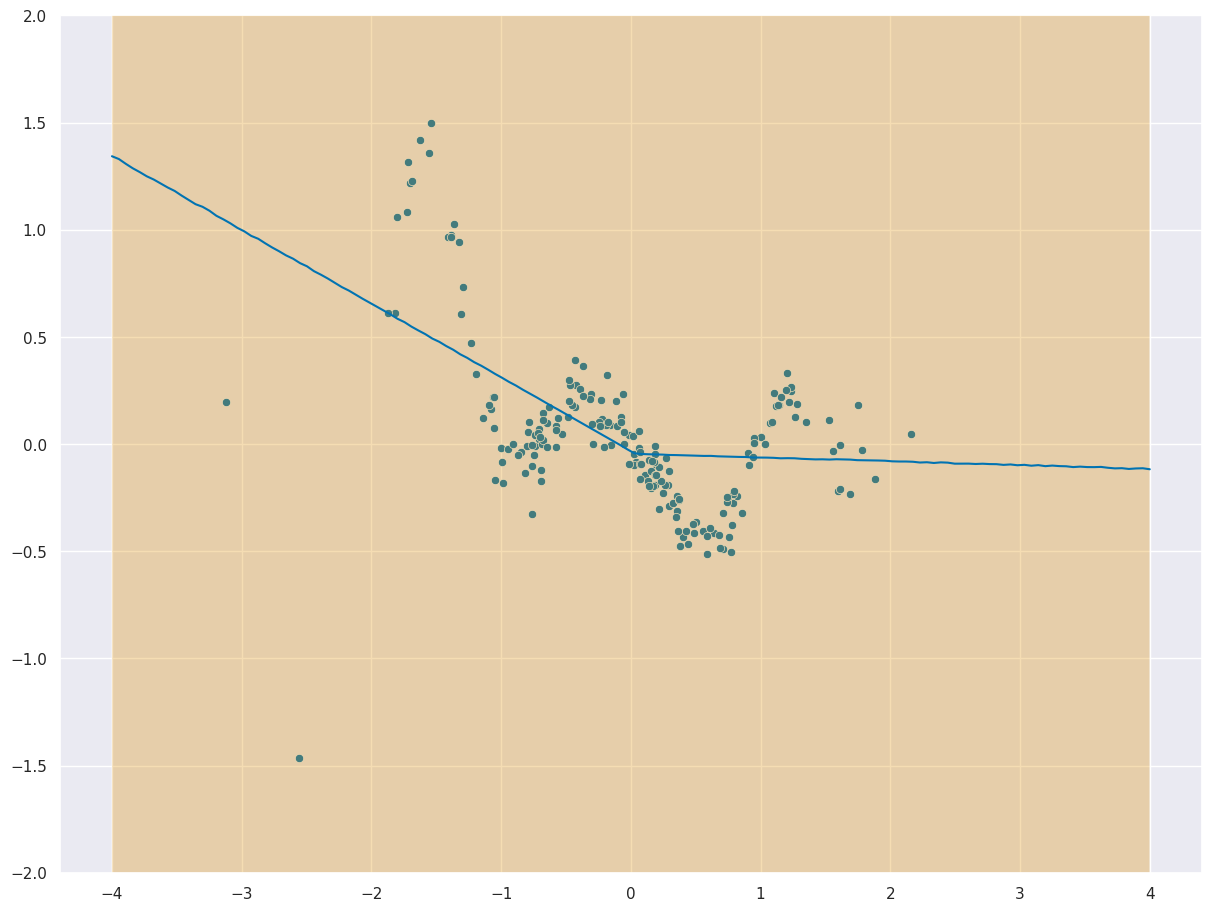

In [111]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 3.1.3 Multiple Passes (n=50)

In [100]:
# 50 passes over the dataset
n_passes = 50
X_multiple_train, y_multiple_train = jnp.tile(X_train, n_passes), jnp.tile(y_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [101]:
# Run infinite-memory aov lofi
bel, _ = lofi_estimator.scan(X_multiple_train, y_multiple_train)

Running for 10,000 iterations: 100%|██████████| 10000/10000 [01:06<00:00, 150.76it/s]


In [102]:
pred_mean, pred_cov = vmap(lofi_ppd)(X_grid)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

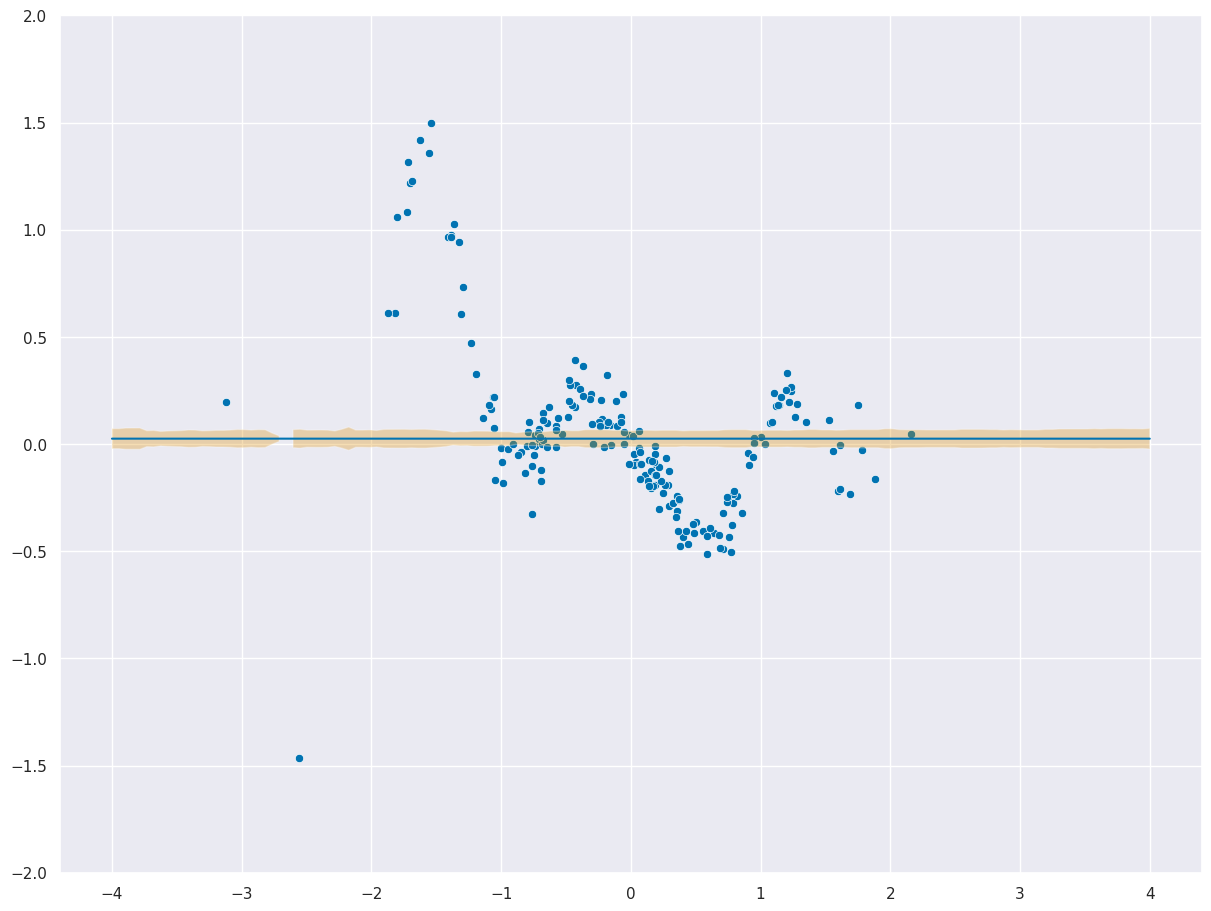

In [103]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);